In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict as dd
from tqdm.notebook import tqdm
from torchvision.transforms import v2
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
mainfolder = r"C:\Users\tonyt\Downloads\archive (1)\compressed_dataset"


In [2]:
# We use this data to choose a random country from which to choose an image out
# of all og the countries. We will generate batches with this.

# Amount of images per country
data_per_country = {}

# Mappings country -> Int and viceversa
country_to_int = {}
int_to_country = {}

# Number of countries (is updated after for loop)
number_countries = 0

# Total amount of images
total_data = 0

i = 0
for country in os.listdir(mainfolder):

    country_to_int[country] = i
    int_to_country[i] = country
    i += 1

    amount = len(os.listdir(os.path.join(mainfolder, country)))
    data_per_country[country] = amount
    total_data += amount

number_countries = i

probabilities = [0]*number_countries


for key, value in data_per_country.items():
    probabilities[country_to_int[key]] = value/total_data


print(country_to_int)
print(int_to_country)
print(data_per_country)
print(probabilities)
print(total_data, number_countries)

{'Aland': 0, 'Albania': 1, 'American Samoa': 2, 'Andorra': 3, 'Antarctica': 4, 'Argentina': 5, 'Armenia': 6, 'Australia': 7, 'Austria': 8, 'Bangladesh': 9, 'Belarus': 10, 'Belgium': 11, 'Bermuda': 12, 'Bhutan': 13, 'Bolivia': 14, 'Botswana': 15, 'Brazil': 16, 'Bulgaria': 17, 'Cambodia': 18, 'Canada': 19, 'Chile': 20, 'China': 21, 'Colombia': 22, 'Costa Rica': 23, 'Croatia': 24, 'Curacao': 25, 'Czechia': 26, 'Denmark': 27, 'Dominican Republic': 28, 'Ecuador': 29, 'Egypt': 30, 'Estonia': 31, 'Eswatini': 32, 'Faroe Islands': 33, 'Finland': 34, 'France': 35, 'Germany': 36, 'Ghana': 37, 'Gibraltar': 38, 'Greece': 39, 'Greenland': 40, 'Guam': 41, 'Guatemala': 42, 'Hong Kong': 43, 'Hungary': 44, 'Iceland': 45, 'India': 46, 'Indonesia': 47, 'Iraq': 48, 'Ireland': 49, 'Isle of Man': 50, 'Israel': 51, 'Italy': 52, 'Japan': 53, 'Jersey': 54, 'Jordan': 55, 'Kenya': 56, 'Kyrgyzstan': 57, 'Laos': 58, 'Latvia': 59, 'Lebanon': 60, 'Lesotho': 61, 'Lithuania': 62, 'Luxembourg': 63, 'Macao': 64, 'Madagas

In [3]:
def get_N_Images(n, path=mainfolder):
    """
        Gets 'n' images of the dataset with probabilities 'probabilities' for each country.
        If this is None it get's images with equal probability
    """

    processed_images = torch.empty(n,3,224,224) # ResNet's input size
    labels = torch.empty(n)

    # Define transformation to apply to images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Iterate over n random images
    for i in range(n):

        # This randomly chose indice will dictate what country the image is chose from
        country = np.random.choice(os.listdir(path))

        # Choose a random image from the selected country folder
        image_name = np.random.choice(os.listdir(os.path.join(path, country)))

        # Load and process the image
        image_path = os.path.join(path, country, image_name)
        image = Image.open(image_path)
        processed_image = transform(image)

        # Append the processed image to the list
        processed_images[i] =  processed_image.unsqueeze(0)

        # Append the label
        labels[i] = country_to_int[country]

    return processed_images, labels.long()

def get_countries_threshold(threshold, path=mainfolder):
    """
        Gets list of countries with more or 'n' images.
    """
    countries_threshold = []

    for country in os.listdir(path):
        if len(os.listdir(os.path.join(path, country))) >= threshold:
            countries_threshold.append(country)
    
    return countries_threshold

def get_N_Images_Threshold(n, countries_threshold, path=mainfolder):
    """
        Gets images from countries that have more than 'n' images
    """
    processed_images = torch.empty(n,3,224,224) # ResNet's inpoyut size
    labels = torch.empty(n)

    # Define transformation to apply to images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    countries_threshold = get_countries_threshold(countries_threshold, path=path)

    # Iterate over n random images
    for i in range(n):
        # This randomly chose indice will dictate what country the image is chose from
        country = np.random.choice(countries_threshold)

        # Choose a random image from the selected country folder
        image_name = np.random.choice(os.listdir(os.path.join(path, country)))

        # Load and process the image
        image_path = os.path.join(path, country, image_name)
        image = Image.open(image_path)
        processed_image = transform(image)

        # Append the processed image to the list
        processed_images[i] =  processed_image.unsqueeze(0)

        # Append the label
        labels[i] = country_to_int[country]

    return processed_images, labels.long()

def get_N_Images_Augmentation(n, threshold, path=mainfolder):
    """
        Gets images 'n' from countries with data augmentation for
        countries with less than 'threshold' images
    """
    processed_images = torch.empty(n,3,224,224) # ResNet's inpoyut size
    labels = torch.empty(n)

    # Define transformation to apply to images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Data augmentation transforms
    data_augmentation_transform = v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomRotation(5),
    ])

    countries_threshold = get_countries_threshold(threshold, path=path)

    # Iterate over n random images
    for i in range(n):
        # This randomly chose indice will dictate what country the image is chose from
        country = np.random.choice(os.listdir(path))

        # Choose a random image from the selected country folder
        image_name = np.random.choice(os.listdir(os.path.join(path, country)))

        # Load and process the image
        image_path = os.path.join(path, country, image_name)
        image = Image.open(image_path)
        processed_image = transform(image)

        if country in countries_threshold:
            processed_image = data_augmentation_transform(processed_image)

        # Append the processed image to the list
        processed_images[i] =  processed_image.unsqueeze(0)

        # Append the label
        labels[i] = country_to_int[country]

    return processed_images, labels.long()

['Australia', 'Brazil', 'Canada', 'Finland', 'France', 'Japan', 'Russia', 'South Africa', 'Spain', 'United Kingdom', 'United States']

torch.Size([5, 3, 224, 224])

torch.Size([5, 3, 224, 224])

torch.Size([5, 3, 224, 224])

China


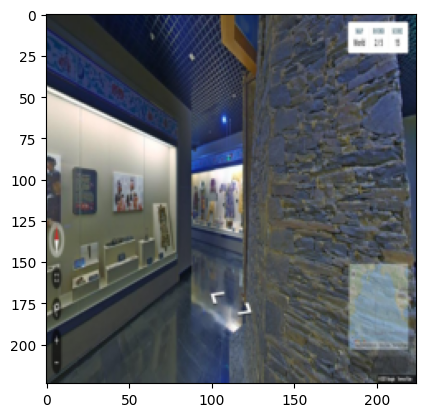

In [4]:
print(get_countries_threshold(1000))
print()

data, _ = get_N_Images(5)

print(data.size())
print()

data, _ = get_N_Images_Threshold(5, 1000)

print(data.size())
print()

data, labels = get_N_Images_Augmentation(5, 100)

print(data.size())
print()

print(int_to_country[labels[0].item()])
plt.imshow(data[0].permute(1, 2, 0))

In [5]:
#from tqdm.notebook import tqdm # This gives me erros :(
import torch.nn.functional as F

def train(model, n=20, nepoch=120, lr=1e-2, step_size=10, threshold=1000):
    """
    Train 'model' on 'nepoch' epochs of size 'n'

    Parameters:
        - 'model'
        - 'n': n images per batch
        - 'nepoch'
        - 'lr'
        - 'step_size': number of epochs after which lr is sacled
        - 'data_augmentation' whether to augment data or not
    """
    # Criterion, optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # Training process. Note: we are not using a validation set
    try:
        for epoch in range(nepoch): #tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            
            inputs, labels = None, None
            if threshold is None:
                inputs, labels = get_N_Images(n)
            else:
                inputs, labels = get_N_Images_Augmentation(n, threshold)

            # inputs = inputs.cuda()
            # labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_for_epoch = loss.item()

            print(f"Loss for epoch {epoch} is {loss_for_epoch:.6f}")
        scheduler.step()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test(model, n, threshold=None):
    """
        Just a simple test function: we pick 'n' random images and test de accuracy
    """
    correct = 0
    softmax = nn.Softmax()
    with torch.no_grad():
        inputs, labels = None, None
        if threshold is None:
            inputs, labels = get_N_Images(n)
        else:
            inputs, labels = get_N_Images_Threshold(n, get_countries_threshold(threshold))
        
        predictions = torch.argmax(softmax(model.forward(inputs)), dim=-1)
        accuracy = torch.count_nonzero(labels == predictions).item()/n
        return accuracy, predictions, labels

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)#.cuda()

Using cache found in C:\Users\tonyt/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\tonyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tonyt\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
train(model, n=600, nepoch=30, lr=1e-1, step_size=5)
torch.save(model.state_dict(), "MyGeoModel")

EPOCH 0


In [ ]:
accuracy, predicted, labels = test(model, 500)

countries_threshhold = get_countries_threshold(1000)

for pred, label in zip(predicted, labels):
    if int_to_country[label.item()] not in countries_threshhold:
        print(f"Country {int_to_country[label.item()]} (label {label}): {pred}")

print(f"{accuracy*100:.2f}%")

In [99]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)#.cuda()
model.load_state_dict(torch.load("./MyGeoModel"))

Using cache found in /Users/guille/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [16]:
accuracy, _, _ = test(model, 500)

print(f"{accuracy*100:.2f}%")

42.80%


In [20]:
accuracy, predictions, labels = test(model, 1000)

for pred, label in zip(predictions, labels):
    if int_to_country[label.item()] not in get_countries_threshold(1000):
        print(f"Country {int_to_country[label.item()]} (Label {label.item()}): {pred}")

print(f"{accuracy*100:.2f}%")

46.40%
